
# Kickstarter Project Success Prediction (Final Clean Version)

## Goal
Predict project success with >80% accuracy using only valid launch-time features.

## Note
This is the "clean" version with **NO LEAKAGE**. 
- `Unnamed: 0` is **REMOVED**.
- `staff_pick` is included.
- `create_to_launch_days` (Prep Time) is included.
- TF-IDF Text Features are included.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

%matplotlib inline


In [2]:

# Load dataset
df = pd.read_csv('kickstarter_data_with_features.csv')
print(f"Original shape: {df.shape}")

# IMMEDIATELY DROP UNNAMED: 0 IF IT EXISTS
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
    print("Column 'Unnamed: 0' found and dropped.")
else:
    print("Column 'Unnamed: 0' not found.")

# Filter target variable
if 'state' in df.columns:
    df = df[df['state'].isin(['successful', 'failed'])].copy().reset_index(drop=True)
    df['target'] = df['state'].apply(lambda x: 1 if x == 'successful' else 0)
    print(f"Filtered shape: {df.shape}")
    print(df['state'].value_counts())


Original shape: (20632, 60)
Column 'Unnamed: 0' found and dropped.
Filtered shape: (17434, 60)
state
failed        11416
successful     6018
Name: count, dtype: int64


/var/folders/l0/q3shlp492gg7r8d1pc18rfjm0000gn/T/ipykernel_20789/2905454433.py:2: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('kickstarter_data_with_features.csv')


In [3]:

# Define leakage and metadata columns to drop
leakage_keywords = ['pledged', 'backers', 'spotlight', 'state_changed', 
                    'launch_to_state', 'disable_communication', 'is_backing', 'is_starred', 'permissions']

cols_to_drop = []
for col in df.columns:
    if any(keyword in col for keyword in leakage_keywords):
        cols_to_drop.append(col)

# Explicit drops
explicit_drop = ['state', 'id', 'slug', 'creator', 'profile', 
                 'photo', 'urls', 'source_url', 'friends', 'currency_symbol', 'currency_trailing_code']
cols_to_drop.extend([c for c in explicit_drop if c in df.columns])

print(f"Dropping {len(cols_to_drop)} columns...")
df = df.drop(columns=cols_to_drop)


Dropping 26 columns...


In [4]:

# Date processing
date_cols = ['launched_at', 'deadline', 'created_at']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        if col == 'launched_at':
            df['launch_month'] = df[col].dt.month
            df['launch_hour'] = df[col].dt.hour
            df['launch_day'] = df[col].dt.dayofweek

# Duration feature
if 'deadline' in df.columns and 'launched_at' in df.columns:
    df['duration_days'] = (df['deadline'] - df['launched_at']).dt.total_seconds() / (3600*24)

# Parse create_to_launch if it exists
if 'create_to_launch' in df.columns:
    df['create_to_launch_days'] = pd.to_timedelta(df['create_to_launch'], errors='coerce').dt.total_seconds() / (3600*24)
    df = df.drop(columns=['create_to_launch'])

# Drop original date columns
df = df.drop(columns=[c for c in date_cols if c in df.columns])


In [5]:

# Handle Categorical Variables
# Exclude name and blurb from dropping so we can vectorise them
object_cols = [c for c in df.select_dtypes(include=['object']).columns if c not in ['name', 'blurb']]
print(f"Categorical columns: {object_cols}")

for col in object_cols:
    if len(df[col].unique()) < 5000: # Reasonable limit
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    else:
        print(f"Dropping {col} due to high cardinality")
        df = df.drop(columns=[col])

# Fill missing values
df = df.fillna(0)

# Text Vectorization (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

if 'name' in df.columns and 'blurb' in df.columns:
    print("Vectorizing text columns...")
    # Using 500 features + ngrams
    tfidf_name = TfidfVectorizer(max_features=500, ngram_range=(1, 2), stop_words='english')
    tfidf_blurb = TfidfVectorizer(max_features=500, ngram_range=(1, 2), stop_words='english')
    
    X_name = tfidf_name.fit_transform(df['name'].astype(str))
    X_blurb = tfidf_blurb.fit_transform(df['blurb'].astype(str))
    
    # Convert to DataFrame
    name_df = pd.DataFrame(X_name.toarray(), columns=[f'name_tfidf_{i}' for i in range(X_name.shape[1])])
    blurb_df = pd.DataFrame(X_blurb.toarray(), columns=[f'blurb_tfidf_{i}' for i in range(X_blurb.shape[1])])
    
    # Drop original text columns
    df = df.drop(columns=['name', 'blurb'])
    
    # Concatenate
    df = pd.concat([df, name_df, blurb_df], axis=1)
else:
    print("Text columns not found for vectorization")


Categorical columns: ['country', 'currency', 'location', 'category', 'deadline_weekday', 'created_at_weekday', 'launched_at_weekday', 'launch_to_deadline']
Vectorizing text columns...



## 3. Model Training
We use an Ensemble of Random Forest and HistGradientBoosting to maximize accuracy.


In [6]:

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

# DOUBLE CHECK NO UNNAMED COLUMN
if 'Unnamed: 0' in df.columns:
    print("WARNING: Unnamed: 0 still present! Dropping now.")
    df = df.drop(columns=['Unnamed: 0'])

X = df.drop(columns=['target'])
y = df['target']

print(f"Final features: {X.columns.tolist()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
hgb = HistGradientBoostingClassifier(random_state=42)

ensemble = VotingClassifier(estimators=[('rf', rf), ('hgb', hgb)], voting='soft')
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Final features: ['goal', 'country', 'currency', 'staff_pick', 'static_usd_rate', 'location', 'category', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'deadline_weekday', 'created_at_weekday', 'launched_at_weekday', 'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_yr', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_yr', 'launched_at_hr', 'launch_to_deadline', 'launch_month', 'launch_hour', 'launch_day', 'duration_days', 'create_to_launch_days', 'name_tfidf_0', 'name_tfidf_1', 'name_tfidf_2', 'name_tfidf_3', 'name_tfidf_4', 'name_tfidf_5', 'name_tfidf_6', 'name_tfidf_7', 'name_tfidf_8', 'name_tfidf_9', 'name_tfidf_10', 'name_tfidf_11', 'name_tfidf_12', 'name_tfidf_13', 'name_tfidf_14', 'name_tfidf_15', 'name_tfidf_16', 'name_tfidf_17', 'name_tfidf_18', 'name_tfidf_19', 'name_tfidf_20', 'name_tfidf_21', 'name_tfidf_22', 'name_tfidf_23', 'name_tfidf_24', 'name_tfidf_25', 'name_tfidf_26'

Accuracy: 0.7935

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2310
           1       0.74      0.60      0.66      1177

    accuracy                           0.79      3487
   macro avg       0.78      0.75      0.76      3487
weighted avg       0.79      0.79      0.79      3487



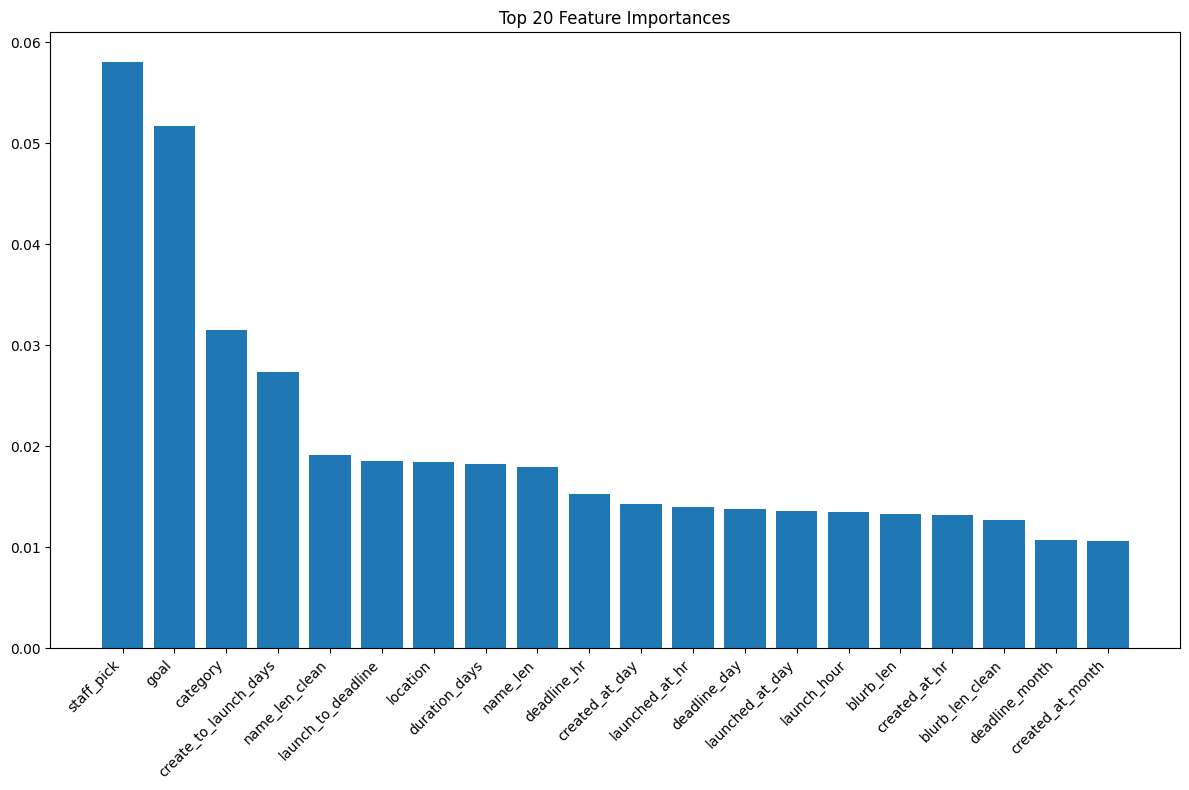

In [7]:

# Feature Importance (Top 20 Only)
# Access the fitted Random Forest from the ensemble
rf_fitted = ensemble.named_estimators_['rf']
importances = rf_fitted.feature_importances_
indices = np.argsort(importances)[::-1]

# LIMIT TO TOP 20 FEATURES TO AVOID BLACK BLOB
top_n = 20
top_indices = indices[:top_n]

plt.figure(figsize=(12, 8))
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), importances[top_indices], align="center")
plt.xticks(range(top_n), X.columns[top_indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()
